In [2]:
import os
import sys
import numpy as np

In [3]:
from skimage import data, io, filters
import matplotlib.pyplot as plt

In [99]:
# dimensions of result image
W = 1200
H = 900
CHANNEL_NUM = 3  # we work with rgb images
MAX_VALUE = 255  # max pixel value, required by ppm header
MATHEMATICAL_ERROR = 0.0004 #maximum error between the boundaries of the tiles
NUMBER_SIDE_TILES = 4

In [5]:
def read_image(path):
    # second line of header contains image dimensions
    w, h = np.loadtxt(path, skiprows=1, max_rows=1, dtype=np.int32)
    # skip 3 lines reserved for header and read image
    image = np.loadtxt(path, skiprows=3, dtype=np.uint8).reshape((h, w, CHANNEL_NUM))
    return image

In [6]:
def write_image(path, img):
    h, w = img.shape[:2]
    # ppm format requires header in special format
    header = f'P3\n{w} {h}\n{MAX_VALUE}\n'
    with open(path, 'w') as f:
        f.write(header)
        for r, g, b in img.reshape((-1, CHANNEL_NUM)):
            f.write(f'{r} {g} {b} ')

In [7]:
def sum_side_pixels_up(tile):
    return float((tile[0,:,:].reshape(-1)).sum())

In [8]:
def sum_side_pixels_down(tile, h):
    return float((tile[h-1,:,:].reshape(-1)).sum())

In [9]:
def sum_side_pixels_left(tile):
    return float((tile[:,0,:].reshape(-1)).sum())

In [10]:
def sum_side_pixels_right(tile, w):
    return float((tile[:,w-1,:].reshape(-1)).sum())

In [187]:
def find_neighbors_new(find_tile, tiles, h, w, side_find_tile):
    # если side_find_tile = 0 - верхняя сторона, 1 - нижняя сторона, 2 - левая сторона, 3 - правая сторона 
    # проверить соседа 4 тайла с 10
    if side_find_tile == 0:
        sum_side_find_tile = sum_side_pixels_up(tiles[find_tile])
    elif side_find_tile == 1:
        sum_side_find_tile = sum_side_pixels_down(tiles[find_tile], h)
    elif side_find_tile == 2:
        sum_side_find_tile = sum_side_pixels_left(tiles[find_tile])
    else:
        sum_side_find_tile = sum_side_pixels_right(tiles[find_tile], w)

    neighbors_tile = np.zeros(2)
    neighbors_tile[:] = -1
    min_error = 1
    
    # for i in range(3,4):
    for i in range(len(tiles)):
        if i == find_tile:
            continue;
        #ищем минимальную погрешность между пикселями граней тайлов
        error_up = abs(sum_side_find_tile /3 - sum_side_pixels_up(tiles[i])/3) / sum_side_find_tile/3 #(w * 255 * 3)
        error_down = abs(sum_side_find_tile/3 - sum_side_pixels_down(tiles[i], h)/3) / sum_side_find_tile/3 #(w * 255 * 3)
        error_left = abs(sum_side_find_tile/3 - sum_side_pixels_left(tiles[i])/3) / sum_side_find_tile/3 #(h * 255 * 3)
        error_right = abs(sum_side_find_tile/3 - sum_side_pixels_right(tiles[i], w)/3) / sum_side_find_tile/3 #(h * 255 * 3)
        # print(sum_side_find_tile, sum_side_pixels_left(tiles[i]))
        # print(i, error_up, error_down, error_left, error_right, sep='\n', end='\n next \n')
        if (min_error > error_up):
            min_error = error_up
            if (min_error <= MATHEMATICAL_ERROR):
              neighbors_tile[0] = i
              neighbors_tile[1] = 0

        if min_error > error_down :
            min_error = error_down
            if (min_error <= MATHEMATICAL_ERROR):
              neighbors_tile[0] = i
              neighbors_tile[1] = 1

        if (min_error > error_left):
            min_error = error_left
            if (min_error <= MATHEMATICAL_ERROR):
              neighbors_tile[0] = i
              neighbors_tile[1] = 2

        if (min_error > error_right):
            min_error = error_right
            if (min_error <= MATHEMATICAL_ERROR):
              neighbors_tile[0] = i
              neighbors_tile[1] = 3

    return neighbors_tile

In [12]:
def left_neighborhood_compilation(first_tile_i, neighbors_tile, tiles, right_true_tile):
    # ставим соседа слева 
    temp = np.array(tiles[int(neighbors_tile[0])])
    tiles[int(neighbors_tile[0])] = tiles[right_true_tile]

    for i in range(right_true_tile, first_tile_i, -1):
        tiles[i] = tiles[i-1]

    tiles[first_tile_i] = temp

    #переворот левого соседа
    if (neighbors_tile[1] == 2):
        tiles[first_tile_i] = np.rot90(tiles[first_tile_i], 2)
    elif (neighbors_tile[1] == 1):
        tiles[first_tile_i] = np.rot90(tiles[first_tile_i], 1)
    elif (neighbors_tile[1] == 0):
        tiles[first_tile_i] = np.rot90(tiles[first_tile_i], 3)

    return tiles

In [13]:
def right_neighborhood_compilation(first_tile_i, neighbors_tile, tiles):
    #ставим соседа справа
    temp = np.array(tiles[int( neighbors_tile[0])])

    #переворот правого соседа
    if (neighbors_tile[1] == 3):
        temp = np.rot90(temp, 2)
    elif (neighbors_tile[1] == 1):
        temp = np.rot90(temp, 3)
    elif (neighbors_tile[1] == 0):
        temp = np.rot90(temp, 1)

    tiles[int( neighbors_tile[0])] = tiles[int( first_tile_i + 1 )]
    tiles[int( first_tile_i + 1 )] = temp
    
    return tiles

In [14]:
def up_neighborhood_compilation(first_tile_i, neighbors_tile, tiles, down_true_tile, number_of_tiles_in_a_row):
    temp = np.array(tiles[int(neighbors_tile[0])])
    tiles[int(neighbors_tile[0])] = tiles[down_true_tile]

    for i in range(down_true_tile, first_tile_i, -number_of_tiles_in_a_row):
        tiles[i] = tiles[i-number_of_tiles_in_a_row]

    tiles[first_tile_i] = temp

    #переворот левого соседа
    if (neighbors_tile[1] == 2):
        tiles[first_tile_i] = np.rot90(tiles[first_tile_i], 1)
    elif (neighbors_tile[1] == 3):
        tiles[first_tile_i] = np.rot90(tiles[first_tile_i], 3)
    elif (neighbors_tile[1] == 0):
        tiles[first_tile_i] = np.rot90(tiles[first_tile_i], 2)

    return tiles

In [15]:
def down_neighborhood_compilation(first_tile_i, neighbors_tile, tiles, number_of_tiles_in_a_row):
    temp = np.array(tiles[int( neighbors_tile[0])])

    if (neighbors_tile[1] == 3):
        temp = np.rot90(temp, 1)
    elif (neighbors_tile[1] == 1):
        temp = np.rot90(temp, 2)
    elif (neighbors_tile[1] == 2):
        temp = np.rot90(temp, 3)

    tiles[int( neighbors_tile[0])] = tiles[first_tile_i + number_of_tiles_in_a_row]
    tiles[first_tile_i + number_of_tiles_in_a_row] = temp

    return tiles

In [16]:
def print_image(nodes, tiles, result_img, h , w, i):
    for (x, y), tile in zip(nodes, tiles):
        result_img[y: y + h, x: x + w] = tile[:h, :w]
 
    output_path = "image_output"+ chr( 65 + i) +".ppm"
    write_image(output_path, result_img)

In [274]:
def error_between_sides(side_find_tile, side_tile, h):
    side_find_tile_temp = np.array(side_find_tile.reshape(-1), dtype=np.int16)
    side_find_tile_temp = np.array(side_find_tile_temp - side_tile.reshape(-1), dtype=np.int16)
    side_find_tile_temp = np.abs(side_find_tile_temp)
    error_up = side_find_tile_temp.sum() / (255 * 3 * h)
    side_tile_temp = np.array(side_tile[::-1, :].reshape(-1), dtype=np.int16)
    side_tile_temp_1 = np.array(side_find_tile.reshape(-1) - side_tile_temp.reshape(-1), dtype=np.int16)
    side_tile_temp_1 = np.abs(side_tile_temp_1)
    error_down = side_tile_temp_1.sum() / (255 * 3 * h)
    return error_down if error_down < error_up else error_up

In [275]:
def solve_puzzle(tiles_folder):
    # create placeholder for result image
    # read all tiles in list
    tiles = [read_image(os.path.join(tiles_folder, t)) for t in sorted(os.listdir(tiles_folder))]
    
    tiles = np.array(tiles)

    result_img = np.zeros((H, W, CHANNEL_NUM), dtype=np.uint8)
    # scan dimensions of all tiles and find minimal height and width
    dims = np.array([t.shape[:2] for t in tiles])
    h, w = np.min(dims, axis=0)

    # compute grid that will cover image
    # spacing between grid rows = min h
    # spacing between grid columns = min w
    x_nodes = np.arange(0, W, w)
    y_nodes = np.arange(0, H, h)
    xx, yy = np.meshgrid(x_nodes, y_nodes)
    nodes = np.vstack((xx.flatten(), yy.flatten())).T

    #Расположение тайлов в правильном порядке
    number_of_tiles_in_a_row = W // w
    number_of_tiles_in_a_column = H // h

    # for i in range(number_of_tiles_in_a_column * number_of_tiles_in_a_row):
    #     # сосед слева
    #     j = i // number_of_tiles_in_a_row
    #     neighbors_tile = find_neighbors_new(j *number_of_tiles_in_a_row, tiles, h, w, 2)
    #     right_tile_i = i % number_of_tiles_in_a_row
    #     while neighbors_tile[0] != -1 and right_tile_i < number_of_tiles_in_a_row - 1:
    #         right_tile_i += 1
    #         tiles = left_neighborhood_compilation(j*number_of_tiles_in_a_row , neighbors_tile, tiles, right_tile_i + j * number_of_tiles_in_a_row)
    #         neighbors_tile = find_neighbors_new(j *number_of_tiles_in_a_row, tiles, h, w, 2)
    #     # сосед справа
    #     right_tile_i = 0 if right_tile_i <= 0 else right_tile_i - 1 
    #     neighbors_tile = find_neighbors_new(right_tile_i + j * number_of_tiles_in_a_row, tiles, h, w, 3)
    #     while neighbors_tile[0] != -1 and right_tile_i < number_of_tiles_in_a_row - 1: 
    #         tiles = right_neighborhood_compilation(right_tile_i+j*number_of_tiles_in_a_row , neighbors_tile, tiles)
    #         right_tile_i += 1
    #         neighbors_tile = find_neighbors_new(right_tile_i + j * number_of_tiles_in_a_row, tiles, h, w, 3)

    #     # сосед сверху
    #     dowm_tile_i = i // number_of_tiles_in_a_row
    #     neighbors_tile = find_neighbors_new(j, tiles, h, w, 0)
    #     while neighbors_tile[0] != -1 and dowm_tile_i < number_of_tiles_in_a_column - 1:
    #         dowm_tile_i += 1
    #         tiles = up_neighborhood_compilation(j, neighbors_tile, tiles, j + dowm_tile_i * number_of_tiles_in_a_row, number_of_tiles_in_a_row)
    #         neighbors_tile = find_neighbors_new(j, tiles, h, w, 0)
    #     # сосед снизу
    #     neighbors_tile = find_neighbors_new(j + dowm_tile_i * number_of_tiles_in_a_row, tiles, h, w, 1)
    #     while neighbors_tile[0] != -1 and dowm_tile_i < number_of_tiles_in_a_column - 1:
    #         tiles = down_neighborhood_compilation(j + dowm_tile_i * number_of_tiles_in_a_row , neighbors_tile, tiles, number_of_tiles_in_a_row)
    #         dowm_tile_i += 1
    #         neighbors_tile = find_neighbors_new(j + dowm_tile_i * number_of_tiles_in_a_row, tiles, h, w, 1)

    # for j in range(number_of_tiles_in_a_column):
    #     # сосед слева
    #     neighbors_tile = find_neighbors_new(j *number_of_tiles_in_a_row, tiles, h, w, 2)
    #     right_tile_i = 0
    #     while neighbors_tile[0] != -1 and right_tile_i < number_of_tiles_in_a_row - 1:
    #         right_tile_i += 1
    #         tiles = left_neighborhood_compilation(j*number_of_tiles_in_a_row , neighbors_tile, tiles, right_tile_i + j * number_of_tiles_in_a_row)
    #         neighbors_tile = find_neighbors_new(j *number_of_tiles_in_a_row, tiles, h, w, 2)
    #     # сосед справа
    #     right_tile_i = 0 if right_tile_i <= 0 else right_tile_i - 1 
    #     neighbors_tile = find_neighbors_new(right_tile_i + j * number_of_tiles_in_a_row, tiles, h, w, 3)
    #     while neighbors_tile[0] != -1 and right_tile_i < number_of_tiles_in_a_row - 1: 
    #         tiles = right_neighborhood_compilation(right_tile_i+j*number_of_tiles_in_a_row , neighbors_tile, tiles)
    #         right_tile_i += 1
    #         neighbors_tile = find_neighbors_new(right_tile_i + j * number_of_tiles_in_a_row, tiles, h, w, 3)

    # for j in range(number_of_tiles_in_a_row):
    #     # сосед сверху
    #     dowm_tile_i = 0
    #     neighbors_tile = find_neighbors_new(j, tiles, h, w, 0)
    #     while neighbors_tile[0] != -1 and dowm_tile_i < number_of_tiles_in_a_column - 1:
    #         dowm_tile_i += 1
    #         tiles = up_neighborhood_compilation(j, neighbors_tile, tiles, j + dowm_tile_i * number_of_tiles_in_a_row, number_of_tiles_in_a_row)
    #         neighbors_tile = find_neighbors_new(j, tiles, h, w, 0)
    #     # сосед снизу
    #     neighbors_tile = find_neighbors_new(j + dowm_tile_i * number_of_tiles_in_a_row, tiles, h, w, 1)
    #     while neighbors_tile[0] != -1 and dowm_tile_i < number_of_tiles_in_a_column - 1:
    #         tiles = down_neighborhood_compilation(j + dowm_tile_i * number_of_tiles_in_a_row , neighbors_tile, tiles, number_of_tiles_in_a_row)
    #         dowm_tile_i += 1
    #         neighbors_tile = find_neighbors_new(j + dowm_tile_i * number_of_tiles_in_a_row, tiles, h, w, 1)

    # fill grid with tiles
    for (x, y), tile in zip(nodes, tiles):
        result_img[y: y + h, x: x + w] = tile[:h, :w]

    # print((tiles[0,:,w-1,:].reshape(-1))[100:112], (tiles[3,0,:,:].reshape(-1))[100:112], sep='\n')
    print(error_between_sides(tiles[0,:,w-1,:], tiles[3,0,:,:], h))

    output_path = "image.ppm"
    write_image(output_path, result_img)

In [276]:
if __name__ == "__main__":
    #directory = sys.argv[1]
    directory = "drive/MyDrive/3Divi/data/0000_0000_0000/tiles"
    solve_puzzle(directory)

0.06520261437908496


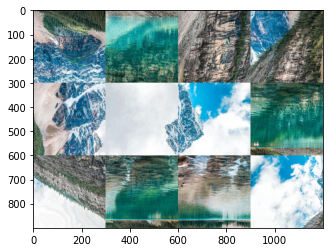

In [215]:
image = read_image("image.ppm")
plt.imshow(image)
plt.savefig("image.png")

In [190]:
if __name__ == "__main__":
    #directory = sys.argv[1]
    directory = "drive/MyDrive/3Divi/data/0000_0000_0001/tiles"
    solve_puzzle(directory)

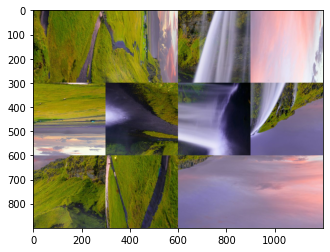

In [191]:
image = read_image("image.ppm")
plt.imshow(image)
plt.savefig("image.png")

In [192]:
if __name__ == "__main__":
    #directory = sys.argv[1]
    directory = "drive/MyDrive/3Divi/data/0000_0000_0002/tiles"
    solve_puzzle(directory)

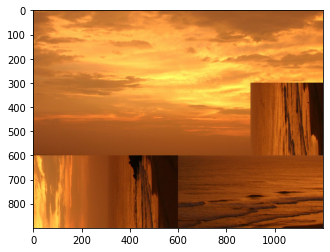

In [193]:
image = read_image("image.ppm")
plt.imshow(image)
plt.savefig("image.png")

In [194]:
if __name__ == "__main__":
    #directory = sys.argv[1]
    directory = "drive/MyDrive/3Divi/data/0000_0001_0000/tiles"
    solve_puzzle(directory)

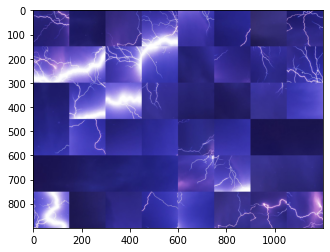

In [195]:
image = read_image("image.ppm")
plt.imshow(image)
plt.savefig("image.png")

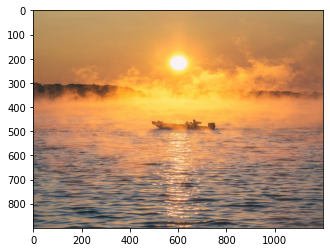

In [109]:
image = read_image("drive/MyDrive/3Divi/data/0000_0002_0001/image.ppm")
plt.imshow(image)
plt.savefig("image_check.png")